In [19]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import cmocean.cm as cm
import cartopy.crs as ccrs
import os
import re

In [159]:
#TODO: do unit conversion and matching, reference ERDAPP metadata sites (also there should be an example file from Susan?)

https://data.cioospacific.ca/erddap/info/index.html?page=1&itemsPerPage=1000

link above can navigate to the metadata for all these datasets

In [4]:
fnames = os.listdir('../../../CIOOS/')

In [34]:
cleaned = []

for file in fnames:
    print(file)
    data = pd.read_csv('../../../CIOOS/' + file)
    if re.search(r'Hakai*', file):
        needed = data[['latitude','longitude','time', 'temperature','salinity', 'depth']]
        needed = needed.rename(columns={"temperature": "TEMPS901", "salinity":"PSALST01"})
    elif re.search(r'IOS_BOT*', file):
        needed = data[['latitude','longitude','time', 'TEMPS901','PSALST01', 'depth']]
    elif re.search(r'IOS_CTD*', file):
        needed = data[['latitude','longitude','time', 'TEMPS901','PSALST01', 'depth']]
    else:
        print('no filename match for ' + file)
    needed
    cleaned = cleaned + [needed]

HakaiWaterPropertiesInstrumentProfileProvisional_catalogue_hakai_org.csv
IOS_BOT_Profiles_data_cioospacific_ca_01.csv


/tmp/ipykernel_1017792/1176865617.py:5: DtypeWarning: Columns (11,12,13,14,23,24,27,30,33,36,39,41,42,44,45,47,48,50,51,54,57,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../CIOOS/' + file)
/tmp/ipykernel_1017792/1176865617.py:5: DtypeWarning: Columns (10,11,12,13,22,23,24,25,26,27,29,30,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../CIOOS/' + file)


IOS_CTD_Profiles_data_cioospacific_ca_02.csv
HakaiWaterPropertiesInstrumentProfileResearch_catalogue_hakai_org.csv
IOS_CTD_Profiles_data_cioospacific_ca.csv
IOS_BOT_Profiles_data_cioospacific_ca_02.csv
IOS_CTD_Profiles_data_cioospacific_ca_01.csv
IOS_BOT_Profiles_data_cioospacific_ca.csv


/tmp/ipykernel_1017792/1176865617.py:5: DtypeWarning: Columns (13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../CIOOS/' + file)


In [52]:
cleaned[0].tail(-1)

,latitude,longitude,time,TEMPS901,PSALST01,depth
1,50.3151,-125.089,2014-08-15T16:21:48Z,9.8034,29.2711,23.82
2,50.3151,-125.089,2014-08-15T16:21:48Z,9.7659,29.2874,28.709
3,50.3151,-125.089,2014-08-15T16:21:48Z,9.7676,29.2906,29.725
4,50.3151,-125.089,2014-08-15T16:21:48Z,9.7713,29.2886,30.743
5,50.3151,-125.089,2014-08-15T16:21:48Z,9.7724,29.2861,31.701
...,...,...,...,...,...,...
38211,50.33921,-125.117638,2023-07-20T21:34:42Z,10.145369,28.519141,19.762818
38212,50.33921,-125.117638,2023-07-20T21:34:42Z,10.114864,28.552273,20.795917
38213,50.33921,-125.117638,2023-07-20T21:34:42Z,10.083073,28.587533,21.78191
38214,50.33921,-125.117638,2023-07-20T21:34:42Z,11.128673,27.043113,11.916438


In [54]:
all_data = pd.concat([cleaned[0].tail(-1), cleaned[1].tail(-1), cleaned[2].tail(-1), cleaned[3].tail(-1), cleaned[4].tail(-1), cleaned[5].tail(-1), cleaned[6].tail(-1), cleaned[7].tail(-1)], ignore_index=True)
all_data['year'] = [i.split('-')[0] for i in all_data['time']]

In [61]:
units = cleaned[1].head(1)
units

,latitude,longitude,time,TEMPS901,PSALST01,depth
0,degrees_north,degrees_east,UTC,degC,PSS-78,m


In [73]:
years = np.arange(2007, 2024)
yearly_data = []
for y in years:
    data_year  = pd.concat([units, all_data[all_data['year'] == str(y)]], ignore_index=True)
    data_year = data_year.drop(columns=['year'])
    data_year.to_csv('CIOOS_' + str(y) + '.csv')

In [75]:
all_out = all_data.drop(columns=['year'])
all_out.to_csv('CIOOS_2007_2023.csv')

## Look at other csv for the units?

In [178]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0][0,:,:]

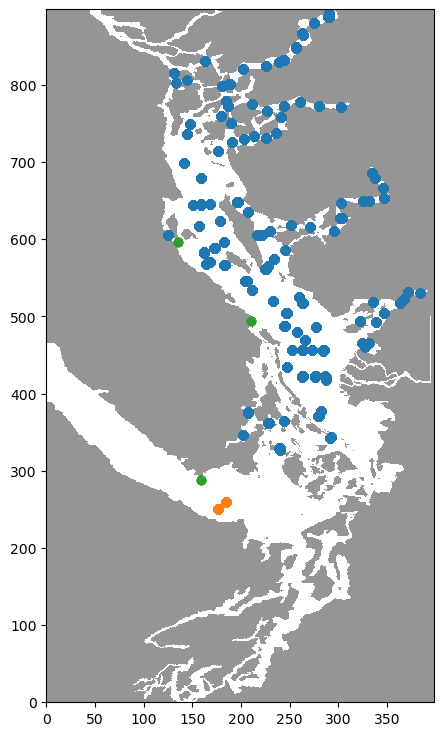

In [191]:
#TODO: make plot that shows all of the matched obs points
comparisons_2023 = pd.read_csv('../ObsModel_202111_CIOOS_20230101_20230805.csv')
comparisons_2022 = pd.read_csv('../ObsModel_202111_CIOOS_20220101_20221231.csv')
comparisons_2019 = pd.read_csv('../ObsModel_202111_CIOOS_20190101_20191231.csv')

# cmap = cm.haline
cmap = 'Greys'
# cmap.set_bad('gray')
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
# salinity = np.ma.masked_array(phys_rivers.vosaline[1, 0], mask=tmask[0])
colours = ax.pcolormesh(tmask*0.5, vmin=0, vmax=1, cmap=cmap)
# cb = fig.colorbar(colours, ax=ax)

ax.scatter(comparisons_2023['i'], comparisons_2023['j'], alpha=0.5)
ax.scatter(comparisons_2022['i'], comparisons_2022['j'], alpha=0.5)
ax.scatter(comparisons_2019['i'], comparisons_2019['j'], alpha=0.5)